In [1]:
import numpy as np 
import pandas as pd
import os
import time

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno
sns.set_style("darkgrid")

color_continuous_blue_sequence = ["#B3E5FC","#81D4FA","#4FC3F7","#29B6F6","#03A9F4","#039BE5","#0288D1","#0277BD","#01579B","#003366"]

# PyTorch
import torch as T
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torchvision import io
from torchvision import transforms
import cv2

# Configure GPU
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

## Load data

In [2]:
# Read data
train_dataset = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/train.csv")
# Dataset dimensions
print(f"Shape of the dataset: {train_dataset.shape}")
# Dataset memory usage
print('Dataset Memory Usage = {:.2f} MB'.format(train_dataset.memory_usage().sum() / 1024**2))
# Show data sample
train_dataset.head()

Shape of the dataset: (33126, 8)
Dataset Memory Usage = 2.02 MB


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


# Exploratory Data Analysis

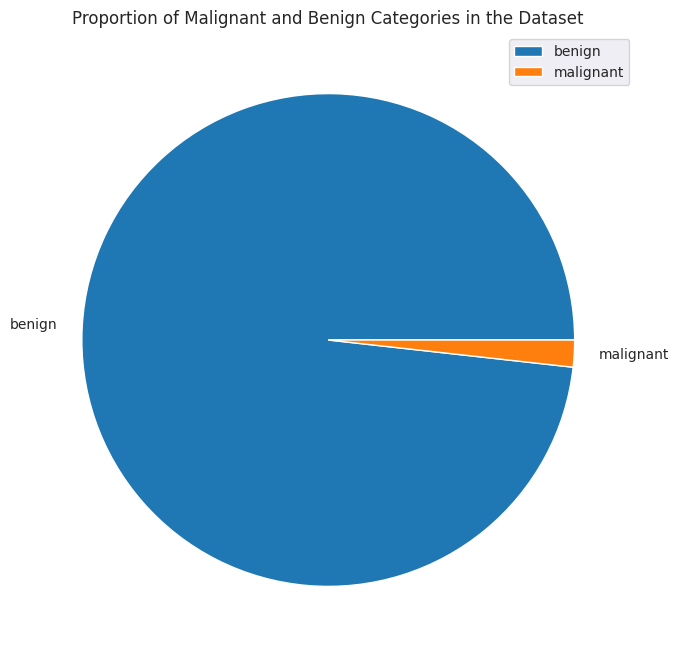

In [3]:
train_dataset['benign_malignant'].value_counts().plot(kind='pie', figsize=(8,8))
plt.title("Proportion of Malignant and Benign Categories in the Dataset")
plt.ylabel("")
plt.legend()

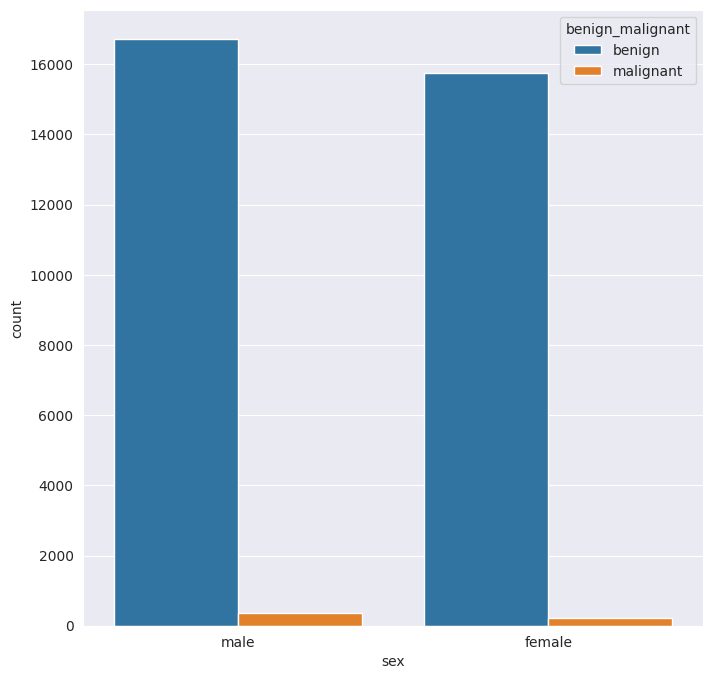

In [4]:
plt.figure(figsize=(8,8))
sns.countplot(data=train_dataset, x='sex', hue='benign_malignant')
plt.show()

## Remove target redundant column

In [5]:
train_dataset = train_dataset.drop(['benign_malignant'], axis = 1)

### Missing values

<Axes: >

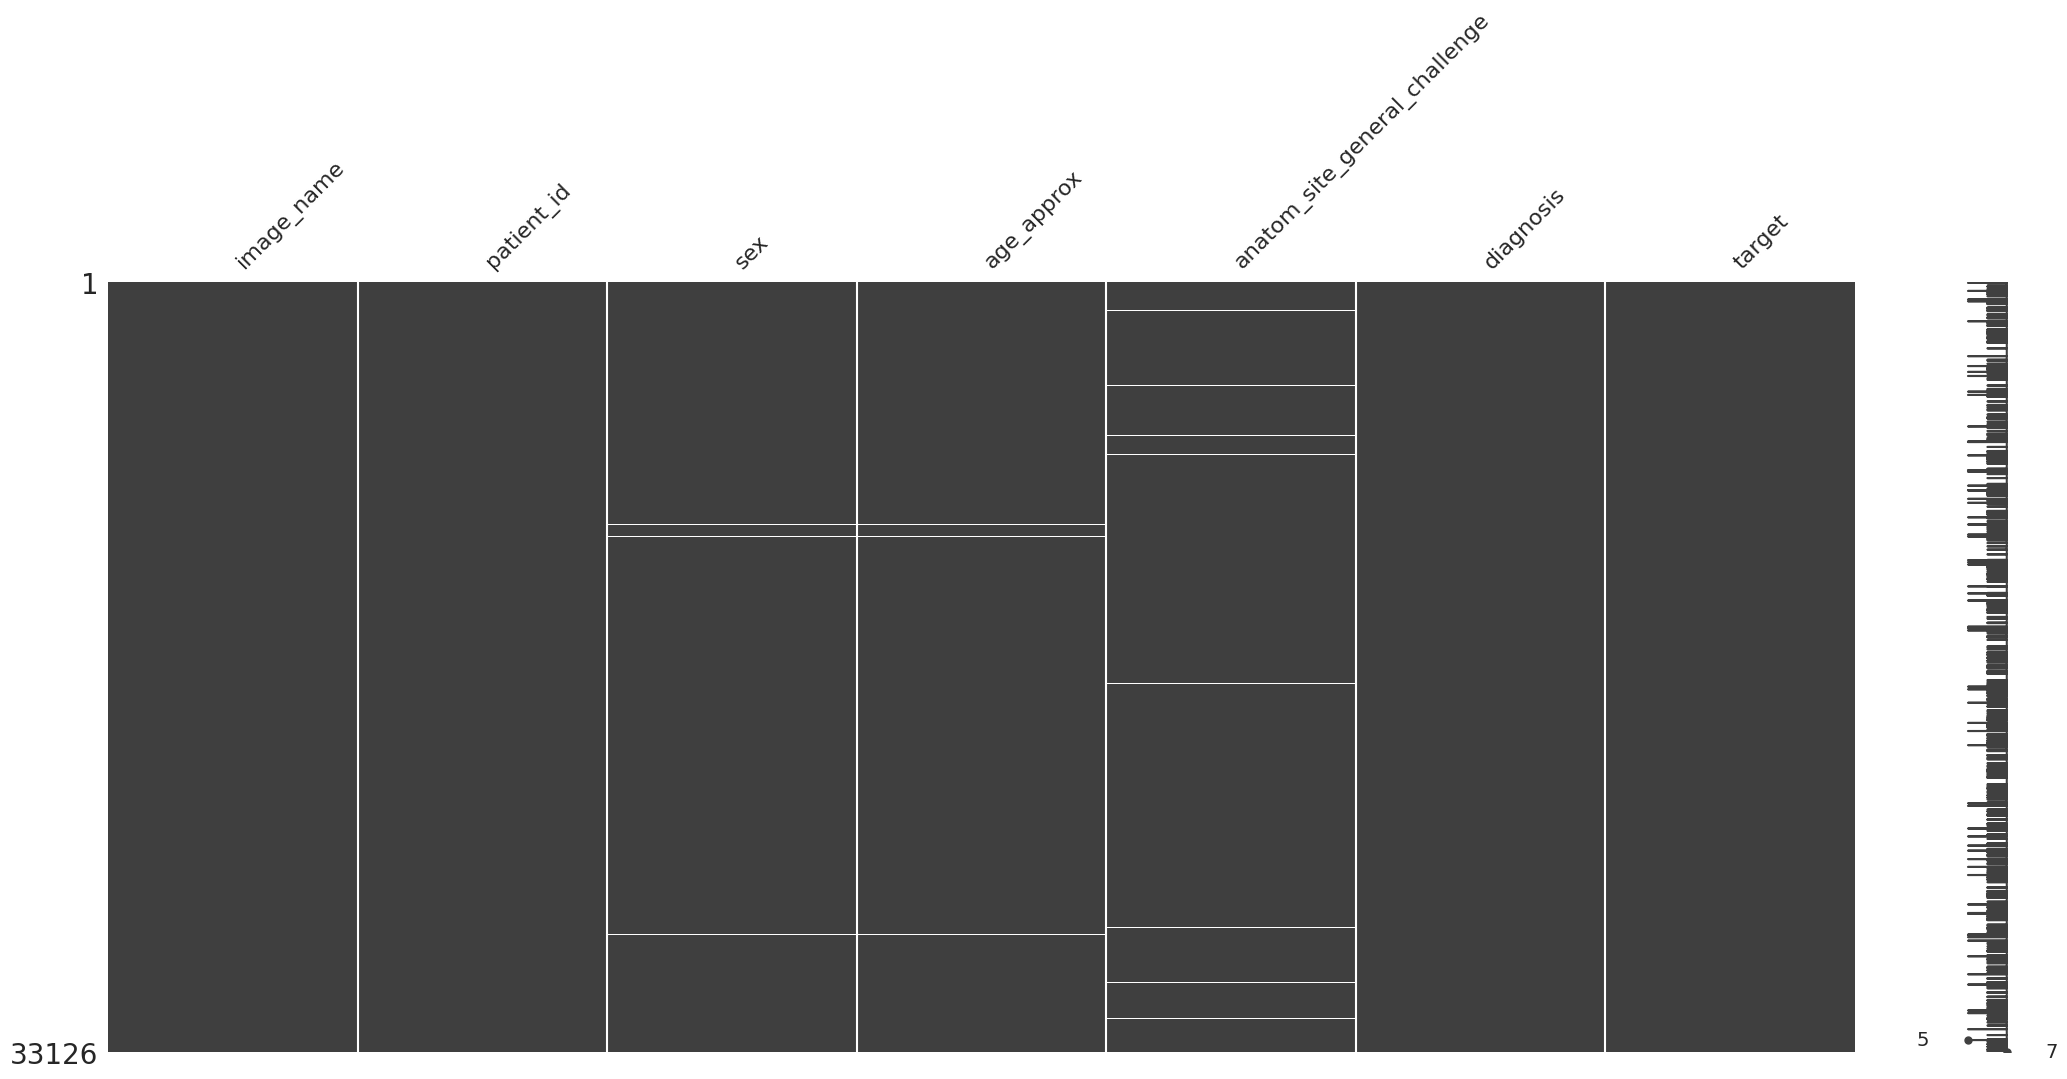

In [6]:
msno.matrix(train_dataset)

In [7]:
# Count of missing values
print("Count of missing values by columns: \n")
train_dataset.isna().sum().sort_values(ascending=False)

Count of missing values by columns: 



anatom_site_general_challenge    527
age_approx                        68
sex                               65
image_name                         0
patient_id                         0
diagnosis                          0
target                             0
dtype: int64

## Dataset samples

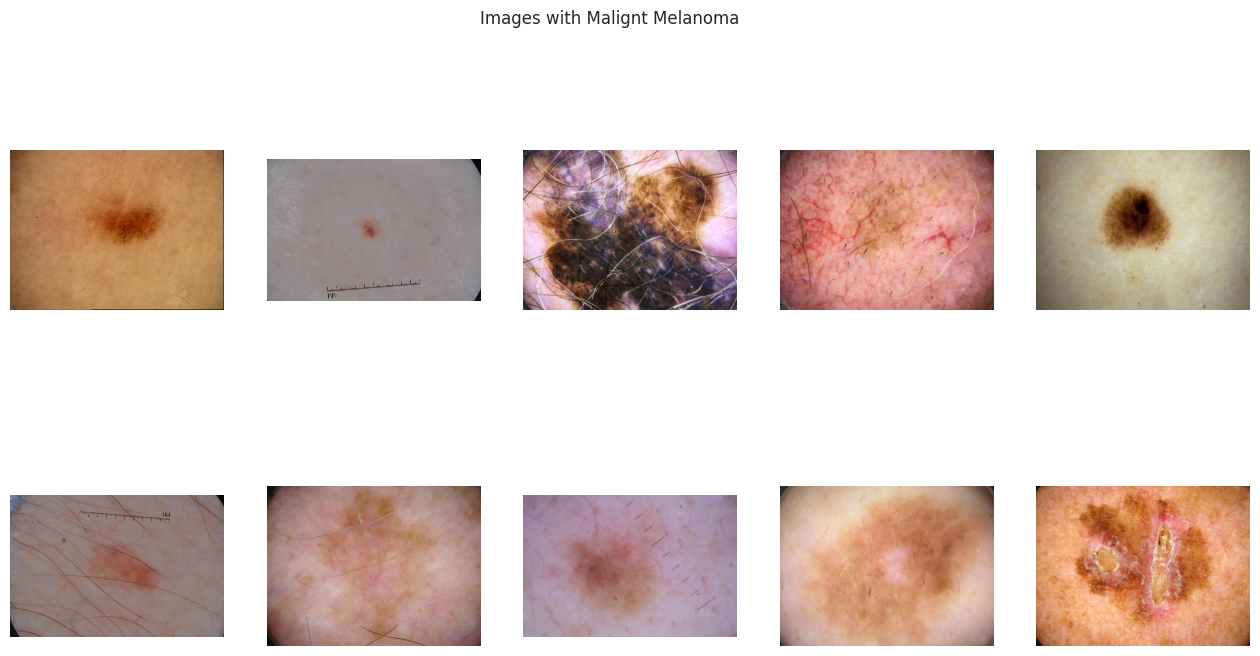

In [8]:
images = train_dataset.loc[train_dataset['target']==1].sample(10)['image_name'].values
plt.figure(figsize=(16,8))
for idx, image_name in enumerate(images):
    image = cv2.imread(f"/kaggle/input/siim-isic-melanoma-classification/jpeg/train/{image_name}.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5, idx+1)
    plt.axis('off')
    plt.imshow(image)
plt.suptitle("Images with Malignt Melanoma")
plt.show()

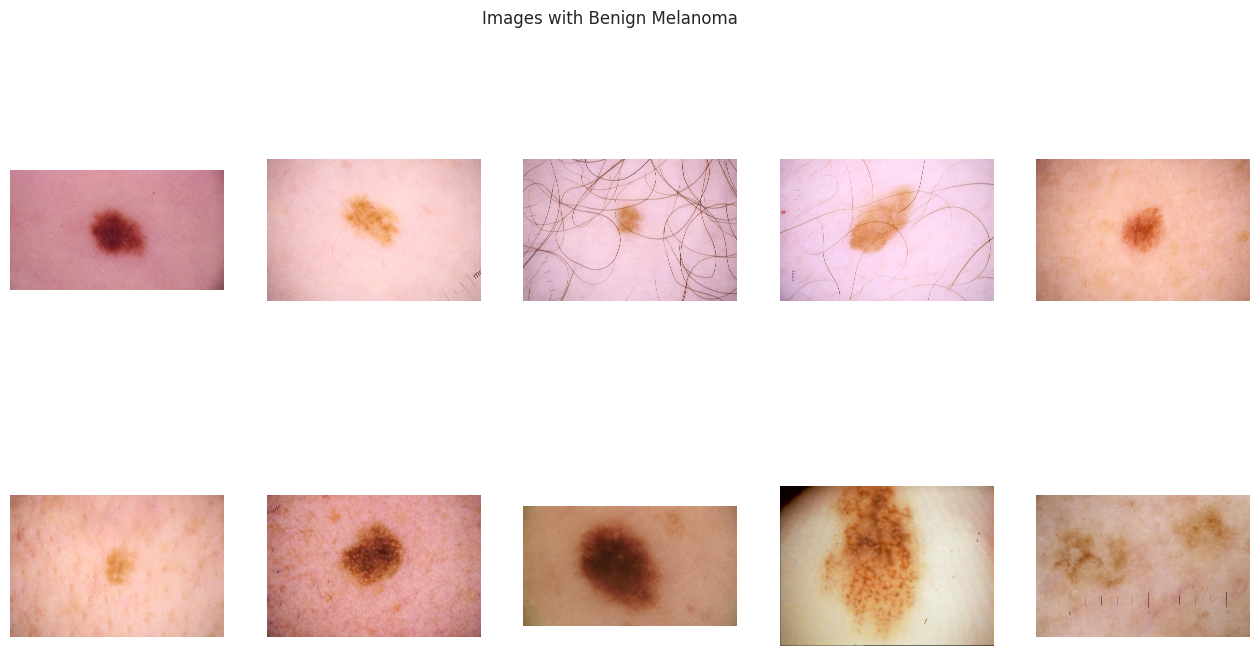

In [9]:
images = train_dataset.loc[train_dataset['target']==0].sample(10)['image_name'].values
plt.figure(figsize=(16,8))
for idx, image_name in enumerate(images):
    image = cv2.imread(f"/kaggle/input/siim-isic-melanoma-classification/jpeg/train/{image_name}.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5, idx+1)
    plt.axis('off')
    plt.imshow(image)
plt.suptitle("Images with Benign Melanoma")
plt.show()

## Create Custom Dataset

In [43]:
class MelanomaDataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        # Path of the images
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        # Read image
        x = cv2.imread(im_path)
        # Read meta features associated to the image
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)
        # Apply transformations to the image
        x = to_pil_image(x)
        if self.transforms:
            x = self.transforms(x)
        # Get the numerical target label (0->benign, 1->malign) 
        if self.train:
            y = self.df.iloc[index]['target']
            return (x, meta), y
        else:
            # For test data
            return (x, meta)
    def __len__(self):
        # Return the length of the DataFrame
        return len(self.df)

## Network architecture

In [11]:
class Network(nn.Module):
    def __init__(self, base_model, n_meta_features: int, device: str):
        super(Network, self).__init__()
        
        self.base_model = base_model
        for param in self.base_model.parameters():
            param.required_grad = False
            
        # Images Stream        
        # Add the stream at the end of pre-trained model
        
        self.base_model.fc = nn.Linear(
            self.base_model.fc.in_features,
            500
        )
        
        # Meta Feature Stream
        self.meta = nn.Sequential(
            nn.Linear(n_meta_features,500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(500,250),
            nn.BatchNorm1d(250),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        # Output layer
        self.output = nn.Linear(500 + 250, 1)        
        # Device
        self.to(device)
        # Optimizer
        self.optim = T.optim.Adam(self.parameters(), lr=0.001)
        # Learning Rate decay and Early Stopping Configuration
        self.early_stop = ReduceLROnPlateau(
            optimizer=self.optim,
            mode="max",
            patience=1,
            verbose=True,
            factor=0.2
        )
        # Loss
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs):
        x, meta = inputs
        cnn_features = self.base_model(x)
        meta_features = self.meta(meta)
        features = T.cat((cnn_features, meta_features), dim=1)
        output = self.output(features)
        return output                

## Augmentation Data

In [39]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(256, 256)),
    transforms.RandomHorizontalFlip(),    
    transforms.RandomVerticalFlip(),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Training

In [13]:
from torchvision import models

## Preprocessing Data

### One hot encoding of categorical feature

In [14]:
train_dataset.dtypes

image_name                        object
patient_id                        object
sex                               object
age_approx                       float64
anatom_site_general_challenge     object
diagnosis                         object
target                             int64
dtype: object

In [15]:
dummies_features = pd.get_dummies(train_dataset['anatom_site_general_challenge'], dummy_na=True, prefix='location')
train_dataset = pd.concat([train_dataset, dummies_features.iloc[:train_dataset.shape[0]]], axis=1)
train_dataset = train_dataset.drop(['anatom_site_general_challenge'], axis=1)
# Standarize the sex feature
train_dataset['sex'] = train_dataset['sex'].map({'male': 1, 'female': 0})
train_dataset['sex'] = train_dataset['sex'].fillna(-1)

# Normalize the age feature
train_dataset['age_approx'] /= train_dataset['age_approx'].max()
train_dataset['age_approx'].fillna(0)

# Fill NaN values of patient id
train_dataset['patient_id'] = train_dataset['patient_id'].fillna(0)

In [16]:
train_dataset.head()

,image_name,patient_id,sex,age_approx,diagnosis,target,location_head/neck,location_lower extremity,location_oral/genital,location_palms/soles,location_torso,location_upper extremity,location_nan
0,ISIC_2637011,IP_7279968,1.0,0.500000,unknown,0,True,False,False,False,False,False,False
1,ISIC_0015719,IP_3075186,0.0,0.500000,unknown,0,False,False,False,False,False,True,False
2,ISIC_0052212,IP_2842074,0.0,0.555556,nevus,0,False,True,False,False,False,False,False
3,ISIC_0068279,IP_6890425,0.0,0.500000,unknown,0,True,False,False,False,False,False,False
4,ISIC_0074268,IP_8723313,0.0,0.611111,unknown,0,False,False,False,False,False,True,False


In [17]:
meta_features = ['sex', 'age_approx'] + [col for col in train_dataset.columns if 'location_' in col]

In [18]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

In [50]:
n_folds = 5
kf = KFold(n_folds)
gkf = GroupKFold(n_folds)

Split dataset

In [51]:
y = train_dataset.loc[:,'target']
X = train_dataset.drop(['target'], axis=1)

In [42]:
from torchvision.transforms.functional import to_pil_image

In [52]:
# Number of epochs
epochs = 12 
# Early Stop patience
es_patience = 3
# Test Time Augmentation rounds
TTA = 3
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, X['patient_id'])):
    print('='*20, "Fold: ", fold, '='*20)
    model_path = f"model_{fold}.pth"
    print("Train idx: ",train_idx)
    print("Validation idx: ",val_idx)
    best_val = 0
    patience = es_patience
    
    
    train = MelanomaDataset(
        df=train_dataset.iloc[train_idx].reset_index(drop=True),
        imfolder='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/',
        train=True,  
        transforms=train_transforms,
        meta_features=meta_features
    )
    
    train_loader = DataLoader(
        dataset=train,
        batch_size=64,
        shuffle=True,
        num_workers=0
    )
    for x, y in train_loader:
        print(len(x))
        print(x[0].shape)
        print(x[1].shape)
        print(y.shape)
        print(len(y))

==================== Fold:  0 ====================
Train idx:  [    0     1     3 ... 33123 33124 33125]
Validation idx:  [    2     5    10 ... 33107 33109 33122]
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([64, 9])
torch.Size([64])
64
2
torch.Size([64, 3, 256, 256])
torch.Size([

KeyboardInterrupt: 

In [ ]:
# Number of epochs
epochs = 12 
# Early Stop patience
es_patience = 3
# Test Time Augmentation rounds
TTA = 3

out_of_folds = np.zeros((len(train_dataset), 1))
skf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, validation_idx) in enumerate(skf.split(X = np.zeros(len(train_dataset)), y=train_dataset['target'], groups=train_dataset['patient_id'].tolist()), 1):
    print('='*20, "Fold: ", fold, '='*20)
    # Path to save the model
    model_path = f"model_{fold}.pth"
    # Best validation score
    best_val = 0
    patience = es_patience
    base_model = models.resnet152(pretrained=True)
    model = Network(
        base_model = base_model,
        n_meta_features= len(meta_features),
        device= device        
    )

    train = MelanomaDataset(
        df=train_dataset.iloc[train_idx].reset_index(drop=True),
        imfolder='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/',
        train=True,
        transforms=train_transforms,
        meta_features=meta_features
    )
    validation = MelanomaDataset(
        df=train_dataset.iloc[validation_idx].reset_index(drop=True),
        imfolder='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/',
        train=True,
        transforms=test_transforms,
        meta_features=meta_features
    )
    
    train_loader = DataLoader(
        dataset=train,
        batch_size=64,
        shuffle=True,
        num_workers=1
    )
    validation_loader = DataLoader(
        dataset=validation,
        batch_size=64,
        shuffle=True,
        num_workers=1
    )
    
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        for x, y in train_loader:
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            
            y = torch.tensor(y, device=device, dtype=torch.float32)
            
            model.optim.zero_grad()
            z = model(x)
            loss = model.loss(z, y.unsqueeze(1))
            loss.backward()
            model.optim.step()
            pred = T.round(T.sigmoid(z))
            
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()
            
            epoch_loss += loss.item()
        train_acc = correct / len(train_idx)
        
        model.eval()
        val_preds = T.zeros((len(validation_idx),1), dtype=T.float32, device=device)
        with T.no_grad():
            for j, (x_validation, y_validation) in enumerate(validation_loader):
                x_validation[0] = T.tensor(x_validation[0], device=device, dtype=T.float32)
                x_validation[1] = T.tensor(x_validation[1], device=device, dtype=T.float32)
                y_validation = T.tensor(y_validation, device=device, dtype=T.float32)
                
                z_validation = model(x_validation)
                val_pred = T.sigmoid(z_validation)
                val_preds[j*validation_loader.batch_size:j*validation_loader.batch_size+x_validation[0].shape[0]] = val_pred
                
                val_acc = accuracy_score(train_dataset.iloc[validation_idx]['target'].values, T.round(val_preds.cpu()))
                val_roc = roc_auc_score(train_dataset.iloc[validation_idx]['target'].values, val_preds.cpu())
                
                print("Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Validation acc {:.3f} | Training time: {}".format(
                    epoch +1,
                    epoch_loss,
                    train_acc,
                    val_acc,
                    val_roc,
                    str(datetime.timedelta(seconds=time.time() - start_time))[:7]
                ))
                
                model.early_stop.step(val_roc)
                
                if val_roc >= best_val:
                    best_val = val_roc
                    patience = es_patience
                    T.save(model, model_path)
                else:
                    patience -= 1
                    if patience == 0:
                        print("Early stopping. Best Val roc_auc: {:.3f}".format(best_val))
                        break
        # Load the best model
        model = T.load(model_path)  
        model.eval()
        val_preds = T.zeros((len(val_idx), 1), dtype=T.float32, device=device)
        with T.no_grad():
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = T.tensor(x_val[0], device=device, dtype=T.float32)
                x_val[1] = T.tensor(x_val[1], device=device, dtype=T.float32)
                y_val = T.tensor(y_val, device=device, dtype=T.float32)
                
                z_val = model(x_val)
                val_pred = T.sigmoid(z_val)
                val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
                out_of_fold[val_idx] = val_preds.cpu().numpy()
                
                
            
                
                